# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
#%connect_info

### Setup params for all runs

Read the parameters file

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. You need to initilaise the model at least once to create the snapshot. The following says 'run in opencl mode and stop once initialisation has finished':

```
python microsim/main.py -ocl -init
```

In [3]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

## Observation Data

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model. See the [README](./observation_data/README.md) for information about how these observations were obtained. They aren't the raw cases, it's actually a model that was fitted to the lagged cases. They need to be made cumulative as this is how they will be compared to the model.

In [4]:
# New per day:
gam_cases = pd.read_csv(os.path.join("../../", "gam_cases.csv"), header=0, names=["Day", "Cases"], )

# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )

assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 16371


## Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model

In [5]:
ITERATIONS = 100  # Number of iterations to run for
NUM_SEED_DAYS = 10  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR, 
    snapshot_filepath = SNAPSHOT_FILEPATH
)

In [6]:
# Results from the manually-calibrated model
manual_results = OpenCLRunner.run_opencl_model_multi(
    repetitions=REPETITIONS,  # Don't use the default, want slightly more robust results
    iterations=ITERATIONS,
    params=PARAMS,
    opencl_dir=OPENCL_DIR, 
    snapshot_filepath=SNAPSHOT_FILEPATH, 
    use_gpu=USE_GPU,
    store_detailed_counts=True,  # Get full info to plot age breakdowns
    multiprocess=False,
    random_ids=False
)

manual_summaries = [x[0] for x in manual_results]
# Store the results as they can be useful as hypothetical observations to test some of the calibration algorithms
pseudo_observations = OpenCLRunner.get_cumulative_new_infections(manual_summaries)

Running models: 100%|██████████| 5/5 [00:52<00:00, 10.48s/it]

.. finished, took 52.39s)


## Plot output summary data

### Total counts of disease status

In [7]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

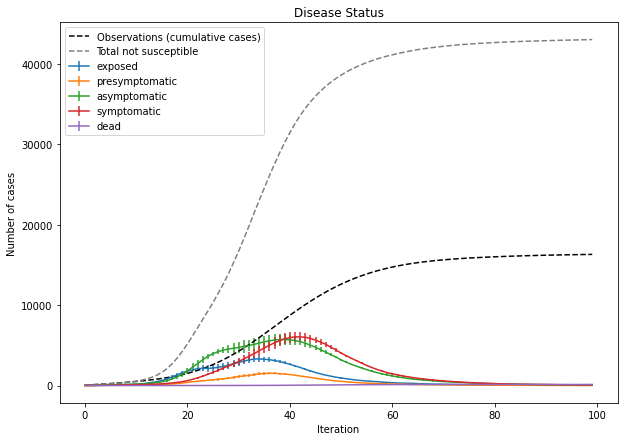

In [8]:
plot_summaries(summaries=manual_summaries, observations=OBSERVATIONS, plot_type="error_bars")

In [9]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [10]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

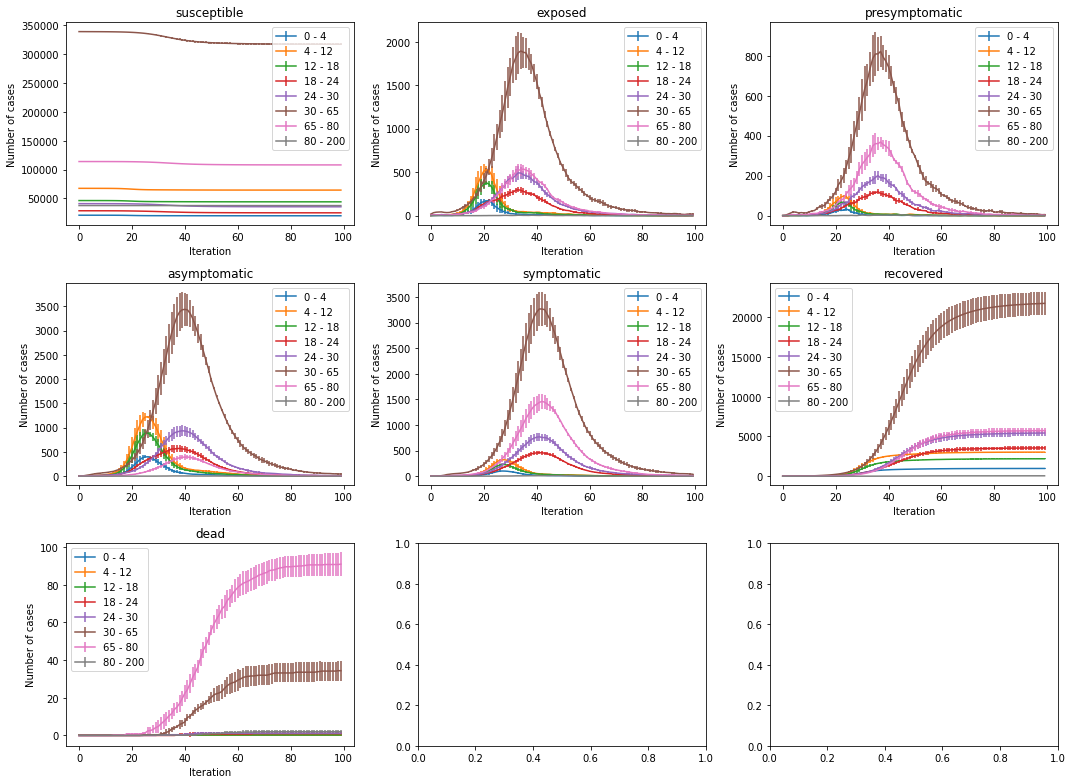

In [11]:
plot_disease_status_by_age(manual_summaries)

### Plot MSOA geodata

#### Load MSOA shapes

In [ ]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [ ]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

In [ ]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)

## Calculating Error: Fitness Function

To calibrate the model we need a fitness function that tells us, for a given result, how similar it is to the observations. The 'observations' (in the [gam_cases.csv](../../gam_cases.csv)) are the number of new infections per day. The model equivalent of this is to look at the number of non-susceptible people per day (i.e. add up all the _non-susceptible_ disease statuses).

Ultimately two arrays showing the cumulative infections per day need to be compared. There are lots of ways to do this. For now, just take the **Euclidean distance (L2 norm)** between the observed number of cases and the simulated number of cases.

This is implemented in `opencl_runner.OpenCLRunner.fit_l2` (see [opencl_runner.py](../opencl_runner.py)).

Note that the model is seeded using the first few days of cases, so at the beginning of a run the simulated data will be identical to the observations. This doesn't matter though because the relative difference between different parameter combinations will be the same regardless.

## Calibration Parameters

Which parameters will we try to calibrate on?

To begin with lets just try the `current_risk_beta` (a general multiplier for risk at locations).

The `run_model_with_params` function has been created for this purpose. Check it works by re-running the model using default parameters

Running models: 100%|██████████| 10/10 [00:24<00:00,  2.49s/it]

.. finished, took 24.89s)
fitness: 45827.06709784077


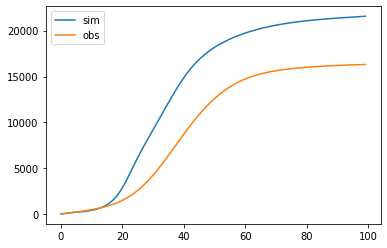

In [12]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions

(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params(np.array([
    0.00235,  # current_risk_beta
    0.35,  # infection_log_scale (default defined in the Params class)
    7.0,  #infection_mode (default defined in the Params class)
    1.0,  # presymptomatic (default defined in default.yml)
    0.75, # asymptomatic (default defined in default.yml)
    0.99  #symptomatic (set to 0.99 so that I can check it is different to the default below)
]) , return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)

# Make sure that the parameter value used in the model was set correctly
assert round(float(out_params0.individual_hazard_multipliers[2]),3) == 0.99

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim")
ax.plot(x, obs0, label="obs")
ax.legend()

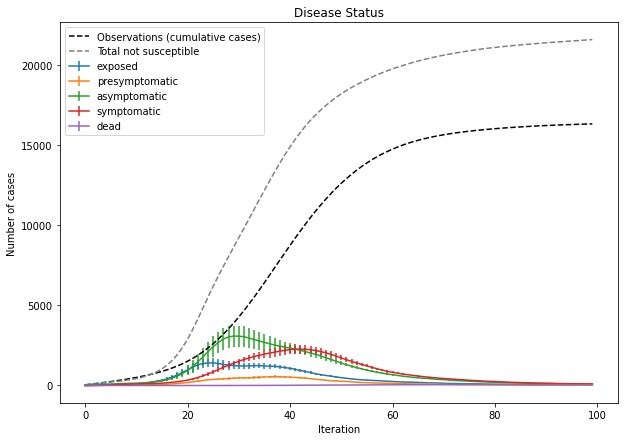

In [10]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

### Calibration

Lots of different methods are available. Simulated annealing? Latin-Hypercube sampling? GA? ABC?

#### Minimization
Start with a simple minimisation algorithm [Nelder-Mead Simplex algorithm](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#nelder-mead-simplex-algorithm-method-nelder-mead) and calibrate on the _current_risk_beta_, the three symptomatic multipliers, and two parameters used to define disease transmissions: _infection_log_scale_ and _infection_mode_.

In [11]:
from scipy.optimize import minimize

x0 = np.array([  # initial guesses for each variable:
    0.00235,  # current_risk_beta
    0.35,  # infection_log_scale
    7.0,  #infection_mode
    1.0,  # presymptomatic
    0.75, # asymptomatic
    1.0  #symptomatic
])

In [ ]:
optimisation_result = minimize(OpenCLRunner.run_model_with_params, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

with open( "./optimisation_result-minimize.pkl", "wb" ) as f:
    pickle.dump( optimisation_result, f)

In [12]:
# Or can optionally load a pickle file
with open( "./optimisation_result-minimize.pkl", "rb" ) as f:
    optimisation_result = pickle.load(f)

Look at the 'optimal' parameters 

In [13]:
np.set_printoptions(suppress=True)
print(optimisation_result.x)

[0.00233679 0.51431182 7.68415629 0.58396896 0.53448522 1.02189788]


Run a model with these parameters to see what happens

In [14]:
#OpenCLRunner.update(store_detailed_counts=True)  # To get the age breakdown
OpenCLRunner.update(repetitions=10) # To reduce some of the confidence intervals

(fitness, sim, obs, out_params, summaries) = \
    OpenCLRunner.run_model_with_params(
        optimisation_result.x, return_full_details=True )

#OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)
OpenCLRunner.update(repetitions=REPETITIONS)

Running models: 100%|██████████| 10/10 [01:31<00:00,  9.15s/it]

.. finished, took 91.52s)


For some reason the algorithm found a set of parameters that perform much worse than the initial ones! Compare the graphs below to the ones above.

Original fitness: 45827
Optimised fitness: 11240


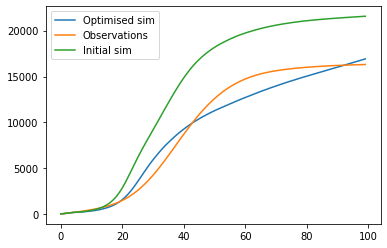

In [15]:
print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")
fig, ax = plt.subplots(1,1)
x = range(len(sim))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries), label="Optimised sim")
ax.plot(x, obs, label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
ax.legend()

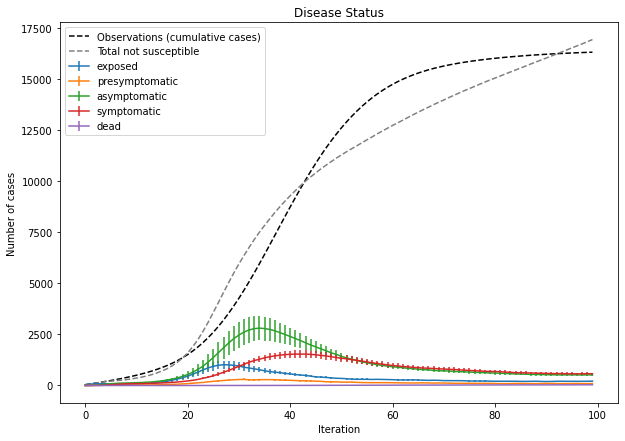

In [17]:
plot_summaries(summaries=summaries, plot_type="error_bars", observations=OBSERVATIONS)
#plot_disease_status_by_age(summaries)

#### Differential evolution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

In [ ]:
from scipy.optimize import differential_evolution
bounds = [  # initial guesses for each variable:
    (0,0.1),  # current_risk_beta, 0.005
    (0,1),  # infection_log_scale, 0.75
    (1,10),  #infection_mode, 7.0
    (0,5),  # presymptomatic multiplier, 1.0
    (0,5), # asymptomatic multiplier, 0.75
    (0,5) # symptomatic multiplier, 1.0 
]

optimisation_result = differential_evolution(OpenCLRunner.run_model_with_params,
                                bounds, updating='immediate', workers=1)
                                #bounds, updating='deferred', workers=2) # paralel version

with open( "./optimisation_result-evolution.pkl", "wb" ) as f:
    pickle.dump( optimisation_result, f)
    
optimisation_result.x, optimisation_result.fun

_TODO: This runs but doesn't terminate after a few days. Need to work out how to find out if it is converging_.

#### Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/) (listed in [pythonMCMC](https://gabriel-p.github.io/pythonMCMC/)).

Note about installing. It is annoying. I did: 
```
conda install mpi4py
pip install pyabc
```
but also had to follow the first proposed solution [here](https://github.com/ipython/ipyparallel/issues/349) (reinstall setuptools and numpy).

Then I got a really annoying error about "`ValueError: Cell is empty`" which happened to be a pickle problem and was resolved by installing older versions: `cloudpickle==1.4.1 distributed==2.17.0` as per [this post](https://stackoverflow.com/questions/63497235/airflow-scheduler-crashes-when-a-dag-is-run)

 - Also adapted Josie's notebook: https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipynb

In [11]:
import pyabc
# Also quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Also need a new distance function that extracts the data from dataframes.
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

To begin with just start with one parameter, the 'presymptomatic multiplier'. Need to decide on a prior distribution that peaks at ~1.0 and has 0 probability for values < 0. A gamma distribution might be OK.

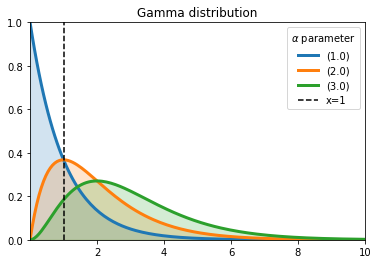

In [12]:
alphas = [1.0, 2.0, 3.0]
x = np.linspace(0.001 ,10, 150)
for alpha in alphas:
    dist = pyabc.Distribution(param=pyabc.RV("gamma", alpha))  # Create the distribution
    y = dist.pdf({"param": x})  # Calculate the pdf at point x
    lines = plt.plot(x, y, label = "(%.1f)"%(alpha), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)

plt.axvline(x=1, ls='--', color="black", label="x=1")
plt.title("Gamma distribution")
plt.ylim(0,1)
plt.legend(title=r"$\alpha$ parameter");

In [13]:
# Priors. These are actually passed around as a dictionary
prior = pyabc.Distribution(presymp=pyabc.RV("gamma",2.0))

Setup ABC. Currently using a single-process sampler because the model is parallelised, but other options are available (see the [sampler docs](    https://pyabc.readthedocs.io/en/update_rtd/sampler.html))

In [14]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=prior, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    )

Define observations

In [15]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

# Hypothetical cases (for testing) slightly randomised
# (these are already the correct length because they were returned by the model)
#y_observed = np.array([ round(x + random.random()) for x in pseudo_observations ])

In [23]:
# Where to store results
db_path = ("sqlite:///" + os.path.join(".", "abc.db"))

In [24]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

INFO:History:Start <ABCSMC(id=2, start_time=2020-11-18 13:34:11.574974, end_time=None)>


Run ABC

In [ ]:
# Only use 1 iteration for speed while testing
#OpenCLRunner.update(repetitions=1)

#history = abc.run(minimum_epsilon=.1, max_nr_populations=10)
history = abc.run(max_nr_populations=5)

#OpenCLRunner.update(repetitions=REPETITIONS)

# The history object only works if it has the associated database too
with open( "./optimisation_result-abc.pkl", "wb" ) as f:
    pickle.dump( history, f)

Can load the history pickle file, but note that you will also need the sqlite database ('abc.db')

In [16]:
with open( "./optimisation_result-abc.pkl", "rb" ) as f:
    history = pickle.load(f)

Visualise the PDFs

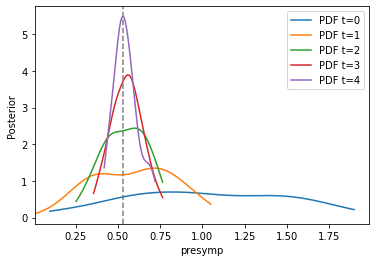

In [17]:
fig, ax = plt.subplots()

for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w,x="presymp", ax=ax,label="PDF t={}".format(t))
#ax.axvline(y_observed, color="k", linestyle="dashed");
ax.axvline(x=0.53, color="grey", linestyle="dashed");
ax.legend()

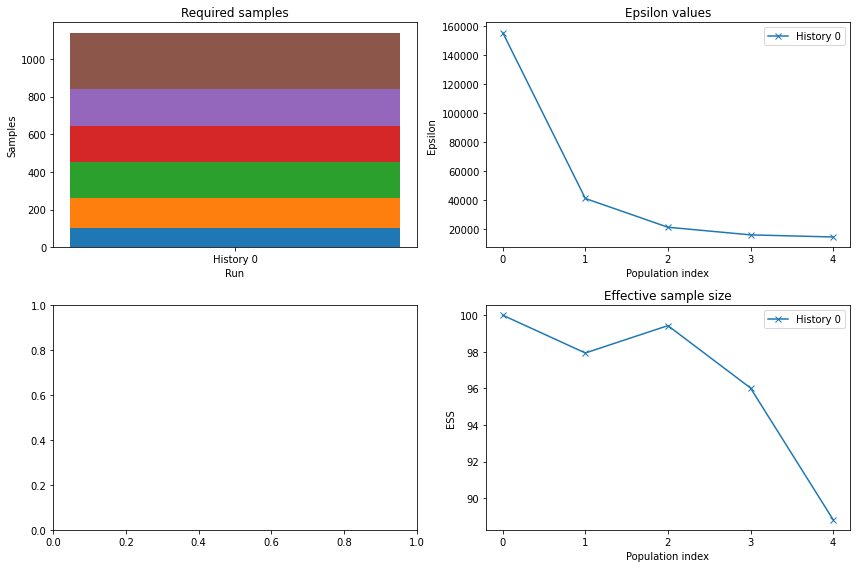

In [18]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Interesting, it thinks that the **presymptomatic multiplier should be around 0.53**, which is lower than expected. Run the simulation again with that number and compare it to the default.

In [22]:
OpenCLRunner.update(repetitions=10)
(fitness, sim, obs, out_params, summaries) = OpenCLRunner.run_model_with_params(np.array([
    0.00235,  # current_risk_beta
    0.35,  # infection_log_scale
    7.0,  #infection_mode
    0.53,  # presymptomatic
    0.75, # asymptomatic
    1.0  #symptomatic
]) , return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)

print(f"fitness: {fitness}")
print(pd.DataFrame({"sim":sim, "pseudo_obs":y_observed, "real_obs1":obs, 
                    "real_obs2":OBSERVATIONS.loc[:len(sim)-1,"Cases"]}))
#list(zip(obs,sim))

Running models: 100%|██████████| 10/10 [00:24<00:00,  2.42s/it]

.. finished, took 24.24s)
fitness: 13922.40465975616
        sim  pseudo_obs  real_obs1  real_obs2
0      37.0          37         37         37
1      75.0          75         75         75
2     115.0         115        115        115
3     156.0         156        156        156
4     199.0         199        199        199
..      ...         ...        ...        ...
95  15842.7       16270      16270      16270
96  15864.6       16281      16281      16281
97  15887.6       16291      16291      16291
98  15912.2       16300      16300      16300
99  15936.8       16309      16309      16309

[100 rows x 4 columns]


Original fitness: 45827
Optimised fitness: 13922


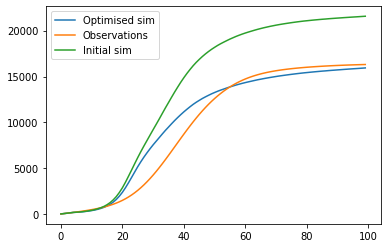

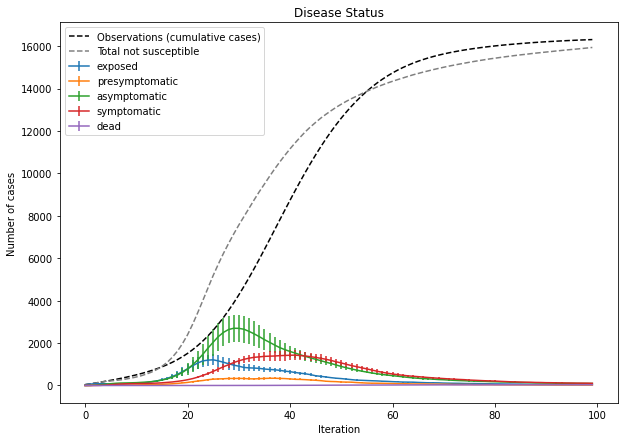

In [23]:
print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")
fig, ax = plt.subplots(1,1)
x = range(len(sim))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries), label="Optimised sim")
ax.plot(x, obs, label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
ax.legend()
plot_summaries(summaries=summaries, plot_type="error_bars", observations=OBSERVATIONS)
#plot_disease_status_by_age(summaries)

#### Approximate Bayesian Computation - Multiple Parameters

As above, but this time with multiple parameters

In [13]:
import pyabc
# Also quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Also need a new distance function that extracts the data from dataframes.
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

Define the priors. This time make them all normal distributions, but will decorate them later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

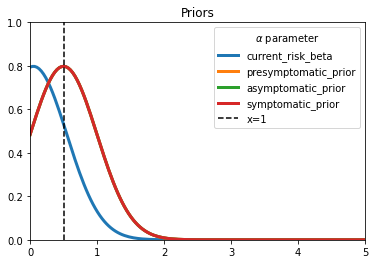

In [14]:
current_risk_beta_rv = pyabc.RV("norm", 0.05, 0.5)
presymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
asymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
symptomatic_rv = pyabc.RV("norm", 0.5, 0.5)

# Note, could create the distribution here (currently done below), then plot the priors directly using, e.g. 
#   y= p riors['current_risk_beta_prior'].pdf(x)
# but for some reason decorating them with the LowerBoundDecorator breaks the call to pdf()

x = np.linspace(-0 ,5, 150)
lines = plt.plot(x, pyabc.Distribution(param=current_risk_beta_rv).pdf({"param": x}),
                 label = "current_risk_beta", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=presymptomatic_rv).pdf({"param": x}),
                 label = "presymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=asymptomatic_rv).pdf({"param": x}),
                 label = "asymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=symptomatic_rv).pdf({"param": x}),
                 label = "symptomatic_prior", lw = 3)

plt.autoscale(tight=True)

plt.axvline(x=0.5, ls='--', color="black", label="x=1")
plt.title("Priors")
plt.ylim(0,1)
plt.legend(title=r"$\alpha$ parameter");

In [15]:
# Decorate the RVs so that they wont go below 0 and create the prior distribution 

priors = pyabc.Distribution(
    current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0),
    presymptomatic = pyabc.LowerBoundDecorator(presymptomatic_rv, 0.0),
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    symptomatic = pyabc.LowerBoundDecorator(symptomatic_rv, 0.0)
    )

#current_risk_beta_prior = pyabc.LowerBoundDecorator(current_risk_beta_prior, 0.0)
#presymptomatic_prior = pyabc.LowerBoundDecorator(presymptomatic_prior, 0.0)
#asymptomatic_prior = pyabc.LowerBoundDecorator(asymptomatic_prior, 0.0)
#symptomatic_prior = pyabc.LowerBoundDecorator(symptomatic_prior, 0.0)

Define the ABC algorithm.

In [16]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    )

Define observations

In [17]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

Where to store results


In [18]:
db_path = ("sqlite:///" + os.path.join(".", "abc2.db"))

In [19]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

INFO:History:Start <ABCSMC(id=4, start_time=2020-11-24 16:47:46.195372, end_time=None)>


Run ABC

In [ ]:
# Only use 1 iteration for speed while testing
#OpenCLRunner.update(repetitions=1)

#history = abc.run(minimum_epsilon=.1, max_nr_populations=10)
history = abc.run(max_nr_populations=1)  # JUST ONE POP TO SEE IF IT WORKS

#OpenCLRunner.update(repetitions=REPETITIONS)

# The history object only works if it has the associated database too
with open( "./optimisation_result-abc2.pkl", "wb" ) as f:
    pickle.dump( history, f)

Can load the history pickle file, but note that you will also need the sqlite database ('abc2.db')

In [20]:
with open( "./optimisation_result-abc2.pkl", "rb" ) as f:
    history = pickle.load(f)

Get the posterior distribution for the final population (needed shortly). This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

In [21]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,presymptomatic,symptomatic,weight
0,413,0.912952,0.003286,1.426849,0.266679,0.041806
1,475,0.103375,0.013000,0.703096,2.058988,0.036190
2,494,0.166479,0.015945,1.301140,0.457668,0.035316
3,420,1.390201,0.006039,0.474472,0.980786,0.030498
4,460,0.078755,0.017132,1.223127,0.255069,0.024887
...,...,...,...,...,...,...
95,498,0.313915,0.006445,0.868904,0.842752,0.004072
96,487,0.272989,0.005264,0.782967,0.917343,0.003949
97,477,0.233122,0.006734,0.843431,1.676632,0.003764
98,491,1.006267,0.004946,0.097677,1.452092,0.002127


Algorithm diagnostics

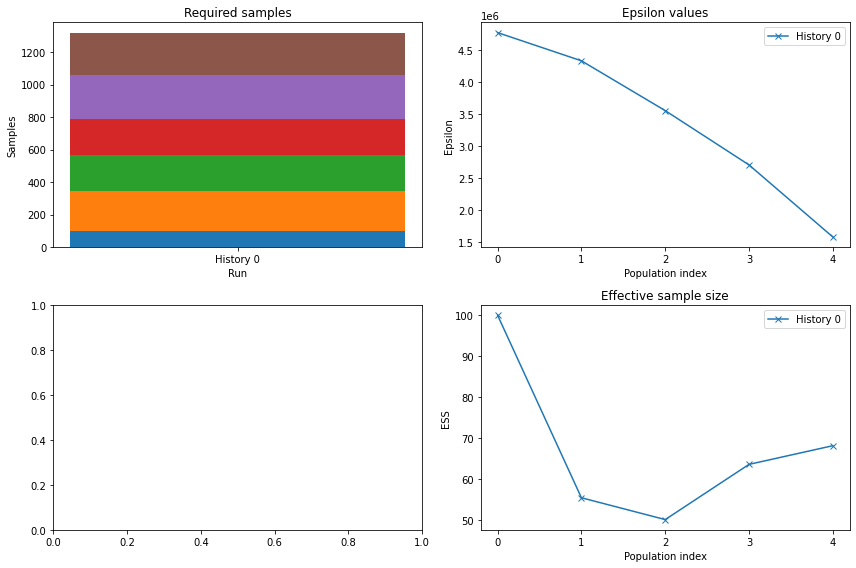

In [22]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Plot the marginal posteriors

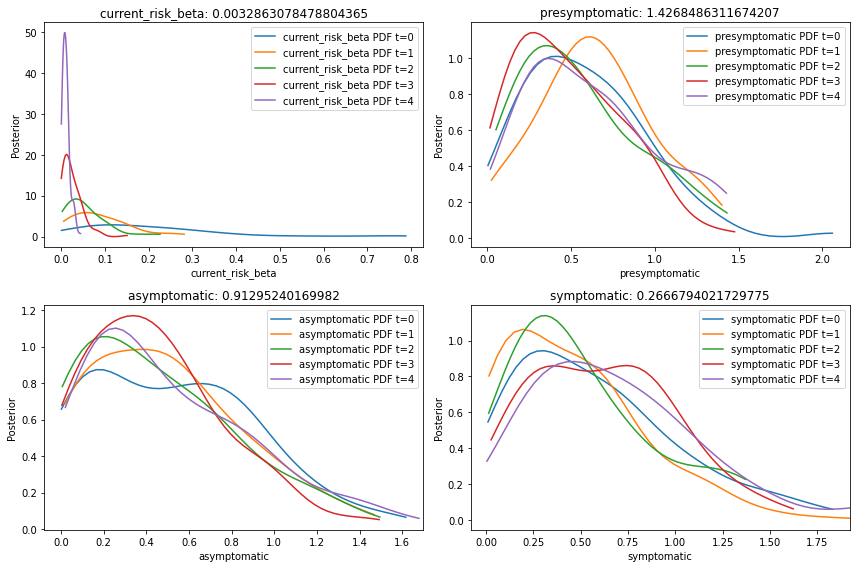

In [23]:
fig, axes = plt.subplots(2,int(len(priors)/2), figsize=(12,8))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}")
        ax.legend()
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
fig.tight_layout()

In [24]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


Now look at the 2D correlations (_I'm not sure how to read this_)

array([[<AxesSubplot:ylabel='asymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='current_risk_beta'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='presymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='asymptomatic', ylabel='symptomatic'>,
        <AxesSubplot:xlabel='current_risk_beta'>,
        <AxesSubplot:xlabel='presymptomatic'>,
        <AxesSubplot:xlabel='symptomatic'>]], dtype=object)

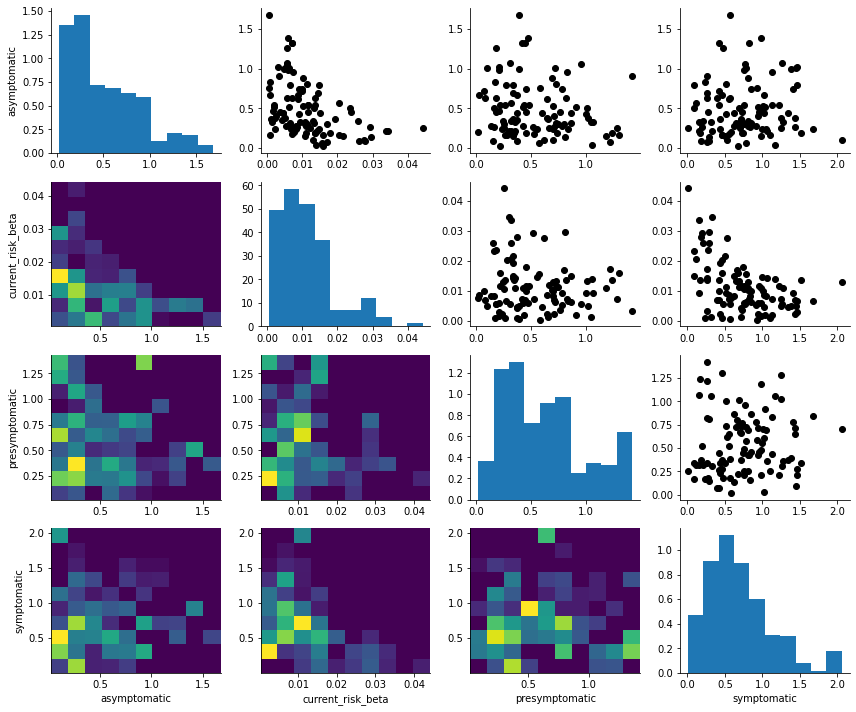

In [25]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:

 - Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations).
 
 - Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs (_I don't think I have quite the right language here_).
 

**ABC Posterior (A) - Find the Mode**

XXXXx

**ABC Posterior (B) - Sample**

Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model.

In [73]:
N_samples = 100
# Sample from the dataframe of posteriors using the weights
df, w = history.get_distribution(m=0, t=history.max_t)
#df['weight'] = w
#df = df.sort_values('weight', ascending=False)
df = df.reset_index()  # So that rows count from 0
# Create a list with row numbers to sample from the dataframe
sample_idx = np.random.choice(
            a=range(history.get_nr_particles_per_population().values[-1]),
            size=N_samples, replace=True, p=w)

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters used in each sample
summaries_l = []  # The symmaries objects

OpenCLRunner.update(repetitions=5)
for idx in sample_idx:
    # Create a dictionary with the parameters and their values for this sample
    param_values = { param:df.loc[idx,str(param)] for param in priors}
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"{idx}, Fitness: {_fitness}")
    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    summaries_l.append(_summaries)
    # Sanity check XXXX CHECK THE PARAMS OBJECT AGAINS THE PARAMS VALUES
OpenCLRunner.update(repetitions=REPETITIONS)

# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])

Running models: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]

.. finished, took 14.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.008380779825592165, 'presymptomatic': 0.16016000672862077, 'asymptomatic': 0.2586166916249634, 'symptomatic': 0.8292633161822343} (Sum result: 4240372.399999999)
24, Fitness: 386991.1814359082


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.014360242360803755, 'presymptomatic': 0.3372328837465188, 'asymptomatic': 0.6995659602072671, 'symptomatic': 0.2576867327136093} (Sum result: 12588703.000000002)
79, Fitness: 1304834.471286776


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.011503171793523878, 'presymptomatic': 0.4876514899008364, 'asymptomatic': 0.5390916494693374, 'symptomatic': 0.7558896853647392} (Sum result: 11382273.600000001)
67, Fitness: 1177064.818438186


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]

.. finished, took 13.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.013564224284461763, 'presymptomatic': 1.242265158481233, 'asymptomatic': 0.18988000920457682, 'symptomatic': 0.16267664648997612} (Sum result: 8545557.4)
87, Fitness: 845078.7501457601


Running models: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]

.. finished, took 12.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.004263970466729567, 'presymptomatic': 0.3772770958383369, 'asymptomatic': 0.3575909044891261, 'symptomatic': 0.7080888397561728} (Sum result: 1261683.1999999997)
13, Fitness: 32877.30423559694


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01594504637810103, 'presymptomatic': 1.3011398144543285, 'asymptomatic': 0.1664792883952367, 'symptomatic': 0.4576679858265011} (Sum result: 12209306.799999999)
91, Fitness: 1250714.814831215


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]

.. finished, took 13.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0060393837417558535, 'presymptomatic': 0.4744720839628022, 'asymptomatic': 1.3902007775544374, 'symptomatic': 0.9807860949194275} (Sum result: 11508876.6)
17, Fitness: 1188895.2406071108


Running models: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]

.. finished, took 11.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0009360476062335371, 'presymptomatic': 0.25976622023476814, 'asymptomatic': 0.1610969971661709, 'symptomatic': 1.104161117857522} (Sum result: 29171.199999999943)
37, Fitness: 113815.56746157355


Running models: 100%|██████████| 5/5 [30:56<00:00, 371.40s/it]

.. finished, took 1856.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.012999674352708095, 'presymptomatic': 0.7030962742573444, 'asymptomatic': 0.10337540931490469, 'symptomatic': 2.0589879025603794} (Sum result: 14842327.399999999)
72, Fitness: 1580009.072047702


Running models: 100%|██████████| 5/5 [00:38<00:00,  7.76s/it]

.. finished, took 38.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.008328648594982713, 'presymptomatic': 0.6985521136731399, 'asymptomatic': 0.2372997567578112, 'symptomatic': 1.042135486306933} (Sum result: 6733532.199999997)
66, Fitness: 663711.8778408595


Running models: 100%|██████████| 5/5 [45:11<00:00, 542.29s/it]   

.. finished, took 2711.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.029564639499820928, 'presymptomatic': 0.81325342672427, 'asymptomatic': 0.13187815480856657, 'symptomatic': 0.28593188910608835} (Sum result: 14997632.0)
48, Fitness: 1556721.2309327193


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007204700657558622, 'presymptomatic': 0.4221795267816209, 'asymptomatic': 1.3200482612167852, 'symptomatic': 0.822582654658476} (Sum result: 12808488.200000003)
39, Fitness: 1330612.3552927352


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.013184972454169934, 'presymptomatic': 0.7298436952748653, 'asymptomatic': 0.32101620844033757, 'symptomatic': 0.6423184338842751} (Sum result: 10664584.199999997)
18, Fitness: 1092501.81425237


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007068973006309369, 'presymptomatic': 0.07765739249989573, 'asymptomatic': 0.6261653962012033, 'symptomatic': 0.38851832322998003} (Sum result: 4557895.600000001)
34, Fitness: 414468.4266979573


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.008380779825592165, 'presymptomatic': 0.16016000672862077, 'asymptomatic': 0.2586166916249634, 'symptomatic': 0.8292633161822343} (Sum result: 4363804.600000001)
24, Fitness: 399580.9368456908


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.011503171793523878, 'presymptomatic': 0.4876514899008364, 'asymptomatic': 0.5390916494693374, 'symptomatic': 0.7558896853647392} (Sum result: 11332196.2)
67, Fitness: 1172233.2596605509


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01361504687404669, 'presymptomatic': 0.2664503081549583, 'asymptomatic': 0.5377425336102746, 'symptomatic': 0.42049196152917506} (Sum result: 10628974.600000003)
60, Fitness: 1091923.9614954148


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007204700657558622, 'presymptomatic': 0.4221795267816209, 'asymptomatic': 1.3200482612167852, 'symptomatic': 0.822582654658476} (Sum result: 12572014.400000002)
39, Fitness: 1305378.7643998656


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.02925080613392855, 'presymptomatic': 0.5202344323918067, 'asymptomatic': 0.26823788350610267, 'symptomatic': 0.189229798895822} (Sum result: 14854973.0)
6, Fitness: 1544466.6603192182


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01361504687404669, 'presymptomatic': 0.2664503081549583, 'asymptomatic': 0.5377425336102746, 'symptomatic': 0.42049196152917506} (Sum result: 10638282.400000002)
60, Fitness: 1092422.8260948963


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.00709359758257286, 'presymptomatic': 0.4427682805256236, 'asymptomatic': 1.3200988503389577, 'symptomatic': 0.42192387045656304} (Sum result: 11471124.799999999)
86, Fitness: 1180160.1267414012


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

.. finished, took 14.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0032863078478804365, 'presymptomatic': 1.4268486311674207, 'asymptomatic': 0.91295240169982, 'symptomatic': 0.2666794021729775} (Sum result: 3518005.4)
10, Fitness: 289998.4399429762


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0060393837417558535, 'presymptomatic': 0.4744720839628022, 'asymptomatic': 1.3902007775544374, 'symptomatic': 0.9807860949194275} (Sum result: 11289319.800000003)
17, Fitness: 1167605.2062355324


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.012904066075175285, 'presymptomatic': 0.2505228361695252, 'asymptomatic': 0.34217376634125873, 'symptomatic': 0.8142032598169862} (Sum result: 9448069.800000003)
56, Fitness: 968472.5305720964


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.010026863329299137, 'presymptomatic': 0.06939584524939311, 'asymptomatic': 0.7238456886437201, 'symptomatic': 0.42268668611729154} (Sum result: 9011915.799999995)
7, Fitness: 914232.7908355946


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007204700657558622, 'presymptomatic': 0.4221795267816209, 'asymptomatic': 1.3200482612167852, 'symptomatic': 0.822582654658476} (Sum result: 12676279.200000001)
39, Fitness: 1316766.6397700848


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0060393837417558535, 'presymptomatic': 0.4744720839628022, 'asymptomatic': 1.3902007775544374, 'symptomatic': 0.9807860949194275} (Sum result: 11209530.8)
17, Fitness: 1158618.6923348166


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.014360242360803755, 'presymptomatic': 0.3372328837465188, 'asymptomatic': 0.6995659602072671, 'symptomatic': 0.2576867327136093} (Sum result: 12847902.799999997)
79, Fitness: 1330357.2332082689


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.03374341089479807, 'presymptomatic': 0.3205891092155466, 'asymptomatic': 0.21154594579098307, 'symptomatic': 0.15963974504495848} (Sum result: 12762540.599999998)
15, Fitness: 1318121.3887474854


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.004263970466729567, 'presymptomatic': 0.3772770958383369, 'asymptomatic': 0.3575909044891261, 'symptomatic': 0.7080888397561728} (Sum result: 1281522.6)
13, Fitness: 34827.516246783955


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

.. finished, took 14.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007184755577213018, 'presymptomatic': 0.525332269603034, 'asymptomatic': 0.17241472516467993, 'symptomatic': 0.5528910661244222} (Sum result: 2477873.1999999993)
92, Fitness: 176061.49179227126


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01937362184163586, 'presymptomatic': 0.3395284397250392, 'asymptomatic': 0.3637442806032447, 'symptomatic': 0.4374237452083855} (Sum result: 12429308.800000003)
28, Fitness: 1290447.3433633314


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.02054918098410567, 'presymptomatic': 0.3234197050517372, 'asymptomatic': 0.5682119983303554, 'symptomatic': 0.10972107576584694} (Sum result: 14597460.399999995)
61, Fitness: 1518015.3711244822


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0060393837417558535, 'presymptomatic': 0.4744720839628022, 'asymptomatic': 1.3902007775544374, 'symptomatic': 0.9807860949194275} (Sum result: 11631826.799999999)
17, Fitness: 1201347.3884609232


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.017132183353320337, 'presymptomatic': 1.2231271217709527, 'asymptomatic': 0.07875453177236436, 'symptomatic': 0.25506876536952405} (Sum result: 9675511.000000002)
57, Fitness: 967474.3477246308


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

.. finished, took 13.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0018007247468782173, 'presymptomatic': 0.9154916963828433, 'asymptomatic': 0.5106113876634544, 'symptomatic': 1.033928608549079} (Sum result: 429054.2)
3, Fitness: 68666.88126484265


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.006070431688092808, 'presymptomatic': 0.4283356333403926, 'asymptomatic': 0.5203222990701514, 'symptomatic': 0.9379024352325607} (Sum result: 5488292.8)
31, Fitness: 523636.8064139495


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

.. finished, took 13.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.00038998750221577293, 'presymptomatic': 0.5830689344800045, 'asymptomatic': 0.750613793711516, 'symptomatic': 0.9271742885470746} (Sum result: 27756.599999999948)
16, Fitness: 113943.29871124496


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007068973006309369, 'presymptomatic': 0.07765739249989573, 'asymptomatic': 0.6261653962012033, 'symptomatic': 0.38851832322998003} (Sum result: 4475696.999999999)
34, Fitness: 407029.1831359516


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

.. finished, took 14.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0032863078478804365, 'presymptomatic': 1.4268486311674207, 'asymptomatic': 0.91295240169982, 'symptomatic': 0.2666794021729775} (Sum result: 3218209.6000000006)
10, Fitness: 257153.3716029405


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.02614629091775948, 'presymptomatic': 0.15194473583325213, 'asymptomatic': 0.08536739332709958, 'symptomatic': 0.28466200792045226} (Sum result: 5620991.599999999)
97, Fitness: 540073.3121318624


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01361504687404669, 'presymptomatic': 0.2664503081549583, 'asymptomatic': 0.5377425336102746, 'symptomatic': 0.42049196152917506} (Sum result: 10653578.600000001)
60, Fitness: 1095037.8889809065


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007096863436949857, 'presymptomatic': 0.7126552182851433, 'asymptomatic': 0.26781104235908837, 'symptomatic': 1.435455037535729} (Sum result: 7083388.800000002)
33, Fitness: 704754.1481828396


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.04425536787875468, 'presymptomatic': 0.2517507140033753, 'asymptomatic': 0.24577998785878558, 'symptomatic': 0.004860427060425818} (Sum result: 14311312.000000004)
2, Fitness: 1482571.1101534253


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

.. finished, took 13.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0006127673860277013, 'presymptomatic': 0.38792060590014615, 'asymptomatic': 1.678686568528952, 'symptomatic': 0.566236190478323} (Sum result: 239971.99999999988)
29, Fitness: 89463.14862713027


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.006022557487900061, 'presymptomatic': 0.21158155918595117, 'asymptomatic': 0.9882697551589463, 'symptomatic': 0.7563955391370272} (Sum result: 7751711.4)
49, Fitness: 775987.5979611014


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.014360242360803755, 'presymptomatic': 0.3372328837465188, 'asymptomatic': 0.6995659602072671, 'symptomatic': 0.2576867327136093} (Sum result: 12840753.600000005)
79, Fitness: 1330895.4211772915


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

.. finished, took 14.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0032863078478804365, 'presymptomatic': 1.4268486311674207, 'asymptomatic': 0.91295240169982, 'symptomatic': 0.2666794021729775} (Sum result: 3396461.7999999984)
10, Fitness: 277193.1345566841


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

.. finished, took 14.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007184755577213018, 'presymptomatic': 0.525332269603034, 'asymptomatic': 0.17241472516467993, 'symptomatic': 0.5528910661244222} (Sum result: 2213877.4000000004)
92, Fitness: 145468.32456696543


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.009145625285008965, 'presymptomatic': 0.7828137311329316, 'asymptomatic': 0.738772716581258, 'symptomatic': 1.404298538797848} (Sum result: 14128433.800000004)
27, Fitness: 1481644.3252432751


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]

.. finished, took 14.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0032863078478804365, 'presymptomatic': 1.4268486311674207, 'asymptomatic': 0.91295240169982, 'symptomatic': 0.2666794021729775} (Sum result: 3263749.1999999997)
10, Fitness: 262470.377819898


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.015620198217640728, 'presymptomatic': 0.5714221082564721, 'asymptomatic': 0.06435314873995351, 'symptomatic': 0.7832905348460575} (Sum result: 8525479.8)
59, Fitness: 863532.2843273898


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

.. finished, took 13.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.003600332736225102, 'presymptomatic': 0.7662055441756633, 'asymptomatic': 0.45496698752857545, 'symptomatic': 0.731605958678715} (Sum result: 1530823.9999999998)
20, Fitness: 63055.36369477223


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

.. finished, took 13.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.00230163470609904, 'presymptomatic': 0.23552945973719178, 'asymptomatic': 0.23558621914368363, 'symptomatic': 0.4355163141160653} (Sum result: 83944.99999999999)
40, Fitness: 107390.5136939013


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.006151558831309836, 'presymptomatic': 0.724560782442171, 'asymptomatic': 1.0045528454004684, 'symptomatic': 0.7825622076071256} (Sum result: 9133821.599999998)
64, Fitness: 924426.7413265153


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

.. finished, took 13.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0009035855633216933, 'presymptomatic': 0.37576833658120773, 'asymptomatic': 0.671659503012865, 'symptomatic': 0.45707590698761746} (Sum result: 66510.59999999999)
77, Fitness: 109507.42155415769


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

.. finished, took 13.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.005601193584331088, 'presymptomatic': 0.17900276020408004, 'asymptomatic': 0.6299297848615891, 'symptomatic': 0.565288348189186} (Sum result: 3612818.4000000004)
9, Fitness: 307719.50042979076


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

.. finished, took 13.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007184755577213018, 'presymptomatic': 0.525332269603034, 'asymptomatic': 0.17241472516467993, 'symptomatic': 0.5528910661244222} (Sum result: 2331574.2000000007)
92, Fitness: 159163.93268551768


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01594504637810103, 'presymptomatic': 1.3011398144543285, 'asymptomatic': 0.1664792883952367, 'symptomatic': 0.4576679858265011} (Sum result: 12054603.400000002)
91, Fitness: 1235815.7436773493


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01594504637810103, 'presymptomatic': 1.3011398144543285, 'asymptomatic': 0.1664792883952367, 'symptomatic': 0.4576679858265011} (Sum result: 12146949.799999997)
91, Fitness: 1242148.9126194492


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0060393837417558535, 'presymptomatic': 0.4744720839628022, 'asymptomatic': 1.3902007775544374, 'symptomatic': 0.9807860949194275} (Sum result: 11485829.200000003)
17, Fitness: 1186340.1028985744


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0032863078478804365, 'presymptomatic': 1.4268486311674207, 'asymptomatic': 0.91295240169982, 'symptomatic': 0.2666794021729775} (Sum result: 3262415.4)
10, Fitness: 262285.9913515779


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.015803858084144806, 'presymptomatic': 0.21954943039070213, 'asymptomatic': 0.02094854466151838, 'symptomatic': 0.6783818924899682} (Sum result: 4906920.999999999)
94, Fitness: 469344.35856892966


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.010089099985980163, 'presymptomatic': 0.7039853426229273, 'asymptomatic': 0.5261656029098184, 'symptomatic': 1.0132275837946025} (Sum result: 11631751.200000001)
65, Fitness: 1204506.8911187681


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0009360476062335371, 'presymptomatic': 0.25976622023476814, 'asymptomatic': 0.1610969971661709, 'symptomatic': 1.104161117857522} (Sum result: 27615.60000000006)
37, Fitness: 113983.62309928561


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.03374341089479807, 'presymptomatic': 0.3205891092155466, 'asymptomatic': 0.21154594579098307, 'symptomatic': 0.15963974504495848} (Sum result: 12725480.800000006)
15, Fitness: 1314870.5797138058


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.010823340133087667, 'presymptomatic': 1.1876318745933478, 'asymptomatic': 0.1493890091770097, 'symptomatic': 0.9762635837318863} (Sum result: 9954870.399999999)
35, Fitness: 1012974.7619521229


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007210171122532701, 'presymptomatic': 1.2887477871749846, 'asymptomatic': 0.24913109428212946, 'symptomatic': 1.2484999883159917} (Sum result: 7787910.2)
50, Fitness: 776753.7414946902


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0032863078478804365, 'presymptomatic': 1.4268486311674207, 'asymptomatic': 0.91295240169982, 'symptomatic': 0.2666794021729775} (Sum result: 3298699.0)
10, Fitness: 265920.32502251497


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.015803858084144806, 'presymptomatic': 0.21954943039070213, 'asymptomatic': 0.02094854466151838, 'symptomatic': 0.6783818924899682} (Sum result: 5006646.199999998)
94, Fitness: 479755.60349536303


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.009403404820432622, 'presymptomatic': 1.0718261345206435, 'asymptomatic': 0.3257600668693813, 'symptomatic': 0.15330671572711613} (Sum result: 6338874.4)
58, Fitness: 605562.4906358385


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01594504637810103, 'presymptomatic': 1.3011398144543285, 'asymptomatic': 0.1664792883952367, 'symptomatic': 0.4576679858265011} (Sum result: 12212681.200000001)
91, Fitness: 1252487.8695227192


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

.. finished, took 14.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0009035855633216933, 'presymptomatic': 0.37576833658120773, 'asymptomatic': 0.671659503012865, 'symptomatic': 0.45707590698761746} (Sum result: 67319.99999999999)
77, Fitness: 109343.43348532642


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.007204700657558622, 'presymptomatic': 0.4221795267816209, 'asymptomatic': 1.3200482612167852, 'symptomatic': 0.822582654658476} (Sum result: 12574184.6)
39, Fitness: 1306858.8657649609


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.014847239903898347, 'presymptomatic': 0.33942112427908644, 'asymptomatic': 0.7882362767986475, 'symptomatic': 0.0850449182193595} (Sum result: 13360435.600000003)
4, Fitness: 1385483.3645866557


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0060393837417558535, 'presymptomatic': 0.4744720839628022, 'asymptomatic': 1.3902007775544374, 'symptomatic': 0.9807860949194275} (Sum result: 11489617.800000003)
17, Fitness: 1187936.9893859858


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0060393837417558535, 'presymptomatic': 0.4744720839628022, 'asymptomatic': 1.3902007775544374, 'symptomatic': 0.9807860949194275} (Sum result: 11446773.199999997)
17, Fitness: 1182487.2945281907


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

.. finished, took 13.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0013656271170931784, 'presymptomatic': 1.053733518989542, 'asymptomatic': 0.3298833116237704, 'symptomatic': 0.3206581491367087} (Sum result: 68190.39999999997)
38, Fitness: 109399.94794642272


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.006444786106958087, 'presymptomatic': 0.868903818320553, 'asymptomatic': 0.3139149495122875, 'symptomatic': 0.8427516996619265} (Sum result: 5259829.799999999)
95, Fitness: 494430.9484738996


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.004263970466729567, 'presymptomatic': 0.3772770958383369, 'asymptomatic': 0.3575909044891261, 'symptomatic': 0.7080888397561728} (Sum result: 1235972.0000000002)
13, Fitness: 29819.32074142535


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.015068209077091856, 'presymptomatic': 0.8634781222084775, 'asymptomatic': 0.4363095484892934, 'symptomatic': 0.6209219988285246} (Sum result: 14501947.2)
83, Fitness: 1512719.1450312645


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.015068209077091856, 'presymptomatic': 0.8634781222084775, 'asymptomatic': 0.4363095484892934, 'symptomatic': 0.6209219988285246} (Sum result: 14414202.400000004)
83, Fitness: 1504177.4488626134


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

.. finished, took 13.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0008455190704512103, 'presymptomatic': 0.17167179294828266, 'asymptomatic': 0.8284599273939139, 'symptomatic': 0.2359722529115182} (Sum result: 68388.4)
98, Fitness: 109223.79993151677


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0032863078478804365, 'presymptomatic': 1.4268486311674207, 'asymptomatic': 0.91295240169982, 'symptomatic': 0.2666794021729775} (Sum result: 3344473.6000000006)
10, Fitness: 271967.6648038145


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01594504637810103, 'presymptomatic': 1.3011398144543285, 'asymptomatic': 0.1664792883952367, 'symptomatic': 0.4576679858265011} (Sum result: 12320420.999999996)
91, Fitness: 1261683.0581491375


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.010022291029113, 'presymptomatic': 0.45487135477352514, 'asymptomatic': 0.7458008774845066, 'symptomatic': 0.8478816187045383} (Sum result: 12139381.799999999)
85, Fitness: 1261222.0470013677


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.01594504637810103, 'presymptomatic': 1.3011398144543285, 'asymptomatic': 0.1664792883952367, 'symptomatic': 0.4576679858265011} (Sum result: 12290894.999999998)
91, Fitness: 1258623.7583466792


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.006151558831309836, 'presymptomatic': 0.724560782442171, 'asymptomatic': 1.0045528454004684, 'symptomatic': 0.7825622076071256} (Sum result: 9380419.6)
64, Fitness: 952786.6717234242


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.009403404820432622, 'presymptomatic': 1.0718261345206435, 'asymptomatic': 0.3257600668693813, 'symptomatic': 0.15330671572711613} (Sum result: 6154237.399999999)
58, Fitness: 585432.1920392147


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.013184972454169934, 'presymptomatic': 0.7298436952748653, 'asymptomatic': 0.32101620844033757, 'symptomatic': 0.6423184338842751} (Sum result: 10492873.8)
18, Fitness: 1074932.720881079


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.009145625285008965, 'presymptomatic': 0.7828137311329316, 'asymptomatic': 0.738772716581258, 'symptomatic': 1.404298538797848} (Sum result: 14093023.999999996)
27, Fitness: 1478032.724028734


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

.. finished, took 13.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0009360476062335371, 'presymptomatic': 0.25976622023476814, 'asymptomatic': 0.1610969971661709, 'symptomatic': 1.104161117857522} (Sum result: 28384.99999999999)
37, Fitness: 113878.36224041863


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]

.. finished, took 13.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0006127673860277013, 'presymptomatic': 0.38792060590014615, 'asymptomatic': 1.678686568528952, 'symptomatic': 0.566236190478323} (Sum result: 222707.40000000005)
29, Fitness: 91388.47065708016


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.006070431688092808, 'presymptomatic': 0.4283356333403926, 'asymptomatic': 0.5203222990701514, 'symptomatic': 0.9379024352325607} (Sum result: 5518981.2)
31, Fitness: 525593.4910793701


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.00564446960306696, 'presymptomatic': 0.9589158892264691, 'asymptomatic': 1.0545162336083445, 'symptomatic': 0.7637758448843962} (Sum result: 9143164.200000001)
44, Fitness: 925791.9421504164


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.034511783081993916, 'presymptomatic': 0.30531966473916194, 'asymptomatic': 0.21512774414728586, 'symptomatic': 0.32570829359940046} (Sum result: 15053992.600000001)
36, Fitness: 1578081.5706292754


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]

.. finished, took 13.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.0009035855633216933, 'presymptomatic': 0.37576833658120773, 'asymptomatic': 0.671659503012865, 'symptomatic': 0.45707590698761746} (Sum result: 78370.00000000003)
77, Fitness: 108171.07535325698


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.012999674352708095, 'presymptomatic': 0.7030962742573444, 'asymptomatic': 0.10337540931490469, 'symptomatic': 2.0589879025603794} (Sum result: 14747994.999999996)
72, Fitness: 1571228.9785324861


Running models: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

.. finished, took 13.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model. {'current_risk_beta': 0.00230163470609904, 'presymptomatic': 0.23552945973719178, 'asymptomatic': 0.23558621914368363, 'symptomatic': 0.4355163141160653} (Sum result: 73830.40000000001)
40, Fitness: 108658.14754522553


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)
Ran Model. {'current_risk_beta': 0.01691329090459222, 'presymptomatic': 0.79977724133839, 'asymptomatic': 0.30588751385967045, 'symptomatic': 0.6611051994789667} (Sum result: 14043188.599999994)
12, Fitness: 1463258.6004950458


Plot the results (the new model posterior)

XXXX HERE - plot the mean and SD of the results (this is the posterior over model results)

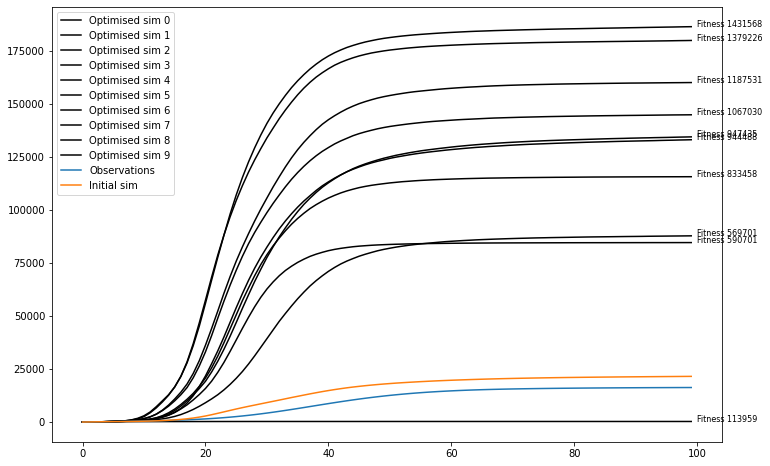

In [72]:
#print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")
fig, ax = plt.subplots(1,1, figsize=(12,8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]), label=f"Optimised sim {i}", color="black")
    ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
ax.legend()


#plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)

#### Machine learning based (neural) density estimation

Something that Sebastion Schmon is experimenting with that I want to try. SBI (simulation-based inference, https://www.mackelab.org/sbi/). I think the idea is that you train a neural network to learn the model, then use that to generate a posterior.